In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.manifold import TSNE
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

# KNN

Метод ближайшего соседа (Nearest neighbor algorithm) - один из простейших методов машинного обучения с учителем
В основе метода лежит гипотеза компактности, которая утверждает что близкие объекты находтся рядом
Данный алгоритм относится к классу жадных алгоритмов, что означает время на обучение алгорима не тратится
Принцип работы алгорима

Тренировка: запоминаем данные $X$ и ответы на них $Y$

Предсказание: 
    
Классификация - для входящего вектора $x_i$, считаем расстояние до всех вектором из обучающей выборки $X$, находим 
индекс ближайшего объекта, возвращаем класс объекта по данному индексу

Регрессия - возвращаем значение ближайшего объекта

<img src="./img/NN.png">
Для примера расмотрим работу алгоритма на датасете качества вин
Алгоритм находится в модуле neighbors, пакета sklearn. Название алгоритма для классификации KNeighborsClassifier
C помощью алгоритма TSNE переведем данные в двумерное измерения, для удобства визуализации

In [3]:
mlp.rcParams['figure.figsize'] = [16.0, 10.0]

In [4]:
plt.style.use('ggplot')

In [5]:
wine_data = load_wine()

In [6]:
df = pd.DataFrame(wine_data['data'], columns=wine_data['feature_names'])

In [7]:
df['Target'] = wine_data['target']

In [8]:
df.rename(columns={'od280/od315_of_diluted_wines': 'od280/od315'}, inplace=True)

In [9]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [10]:
df.shape

(178, 14)

In [11]:
df["Target"].value_counts()

1    71
0    59
2    48
Name: Target, dtype: int64

In [12]:
tsne = TSNE(n_components=2)

In [13]:
scaler = StandardScaler()

In [14]:
x = scaler.fit_transform(df.drop('Target', axis=1))

In [15]:
x = tsne.fit_transform(x)

In [16]:
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))

In [17]:
def print_border(n_neighbors):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(x, df['Target'])
    predict = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    predict = predict.reshape(xx.shape)
    plt.pcolormesh(xx, yy, predict, cmap='terrain');
    sns.scatterplot(x[:, 0], x[:, 1], hue=df['Target'], palette=['red', 'blue', 'green']);

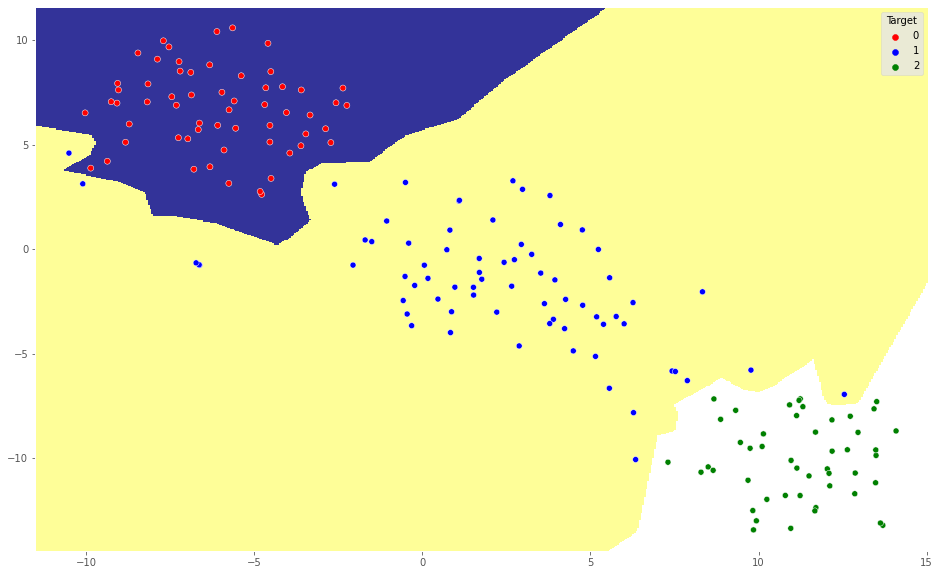

In [18]:
print_border(1)

Данный график показывает разделяющую поверхность для различных классов из данных
Из-за того что в качестве предсказания используется метка ближайшего семпла, алгоритм очень чувствителен к выбросам

<img src="./img/nn_outlier.png">

Из-за выброса у нас есть поверхность предсказания неверной метки класса в глубине другого кластера
Данная проблема решается если мы вместо ближайшего предсказания, будем брать 
    
Для классификации самую встречаемую метку среди $K$ ближайших соседей

Для регрессии возвращаем среднее значение таргета ближайших точек

Эта $K$ и есть первая буква в названии алгоритма

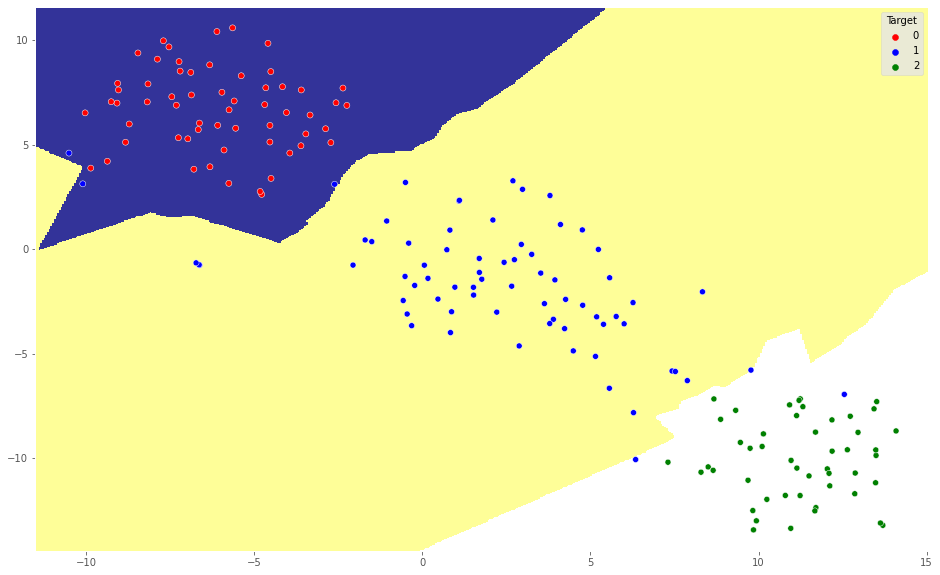

In [19]:
print_border(3)

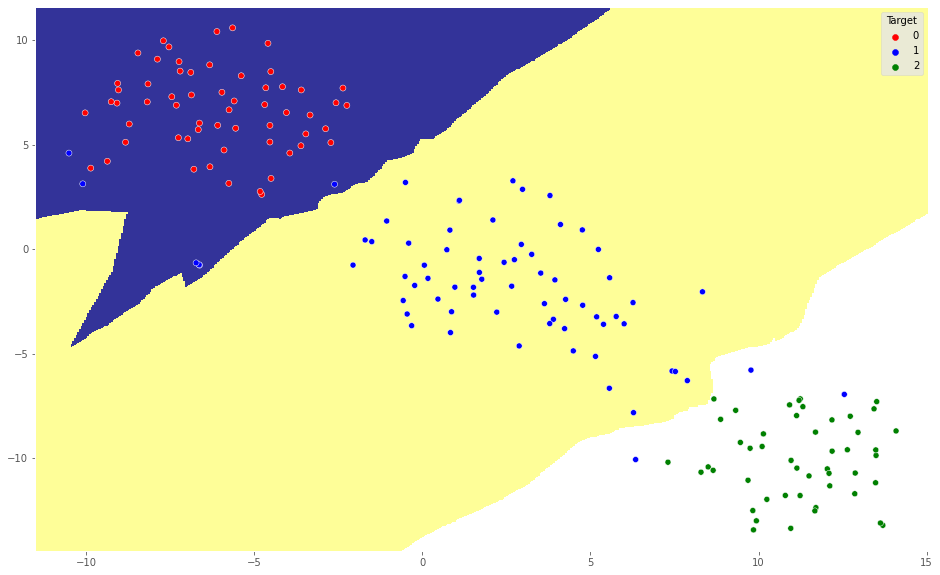

In [20]:
print_border(9)

Как мы видим при увеличении числа соседей граница разделяющей поверхности становится более гладкой
Если мы введем метрику процента ошибки в зависимости от числа соседей, то с помощью валидации мы можем получить оптимальное число соседей

In [21]:
score = []
for i in range(1, 101):
    val = cross_val_score(KNeighborsClassifier(n_neighbors=i), df.drop('Target', axis=1), df['Target'], cv=5).mean()
    score.append(1 - val)

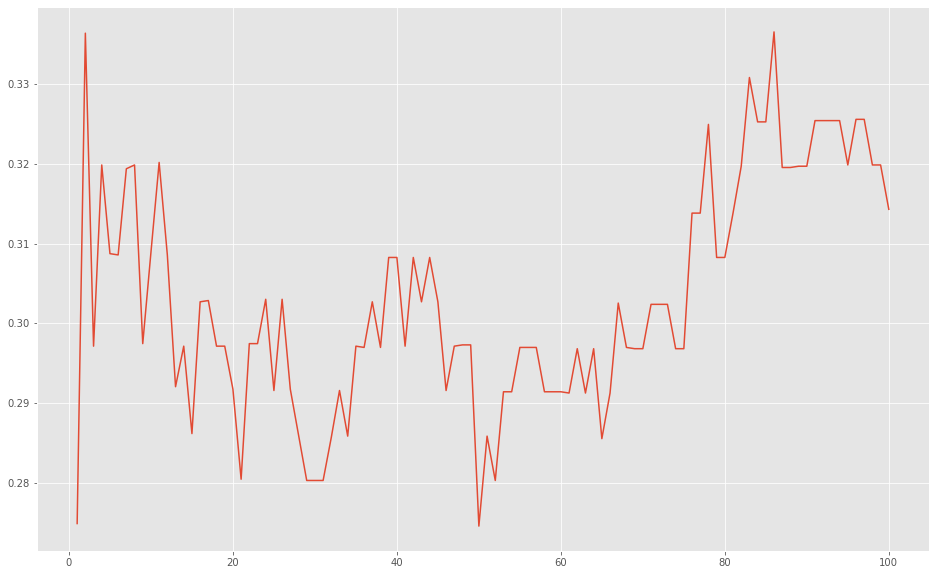

In [22]:
plt.plot(np.arange(1, 101), score);

На данном графике четко видно 2 мимума в еденице и около пятидесяти
Однако так-же видно что качество классификации плохое, процент ошибок в оптимальном случае больше 27%
Это происходит потому что данные в датасете имеют различную шкалу измерения, например признак proline изменяется от 278 до 1680, в то время total_phenols от 0.98 до 3.88
В результате такой разницы мы имеем слишком большую разницу в значении признаков
Чтобы избежать такой ситуации, необходимо отранжировать данные к одной шкале
Сделать это можно с помощью класса <b>StandarScaler</b> пакета sklearn, модуля preprocessing

In [23]:
min(score)

0.27460317460317474

In [24]:
score = []
for i in range(1, 101):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=i))
    ])
    val = cross_val_score(pipe, df.drop('Target', axis=1), df['Target'], cv=5).mean()
    score.append(1 - val)

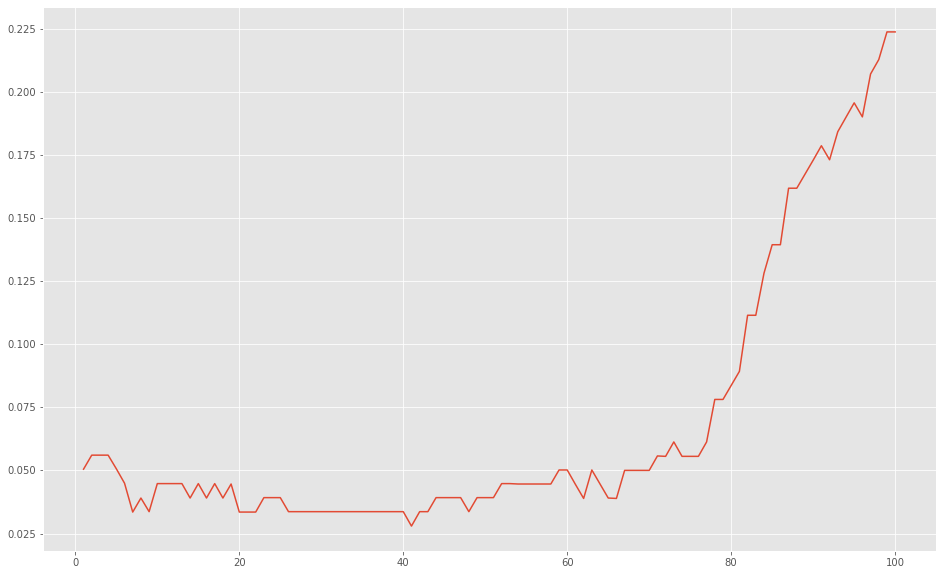

In [25]:
plt.plot(np.arange(1, 101), score);

После нормализации признаков доля ошибок упала почти до 3%, что является хорошим бейзлайном для данной задачи

In [26]:
score = []
for i in range(1, 101):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=i, weights="distance"))
    ])
    val = cross_val_score(pipe, df.drop('Target', axis=1), df['Target'], cv=5).mean()
    score.append(1 - val)

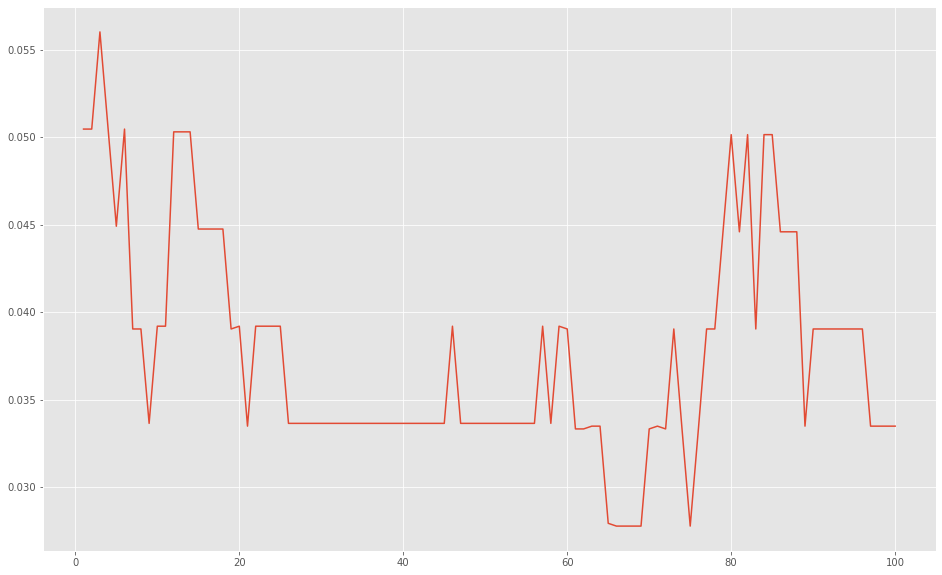

In [27]:
plt.plot(np.arange(1, 101), score);

In [28]:
min(score)

0.0277777777777779

In [29]:
def print_border(n_neighbors):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance")
    clf.fit(x, df['Target'])
    predict = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    predict = predict.reshape(xx.shape)
    plt.pcolormesh(xx, yy, predict, cmap='terrain');
    sns.scatterplot(x[:, 0], x[:, 1], hue=df['Target'], palette=['red', 'blue', 'green']);

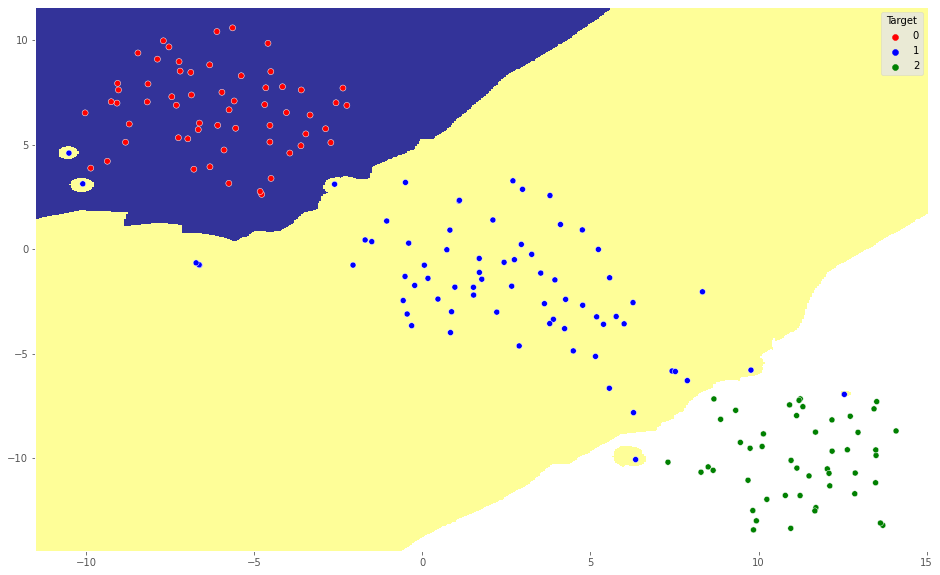

In [30]:
print_border(9)

# Окно парзена

В алгоритме KNN есть существенный недостаток, различные семплы вносят одинаковый одинаковый вклад в пресказание, независимо от их удаленности
Чтобы исправить этот недостаток, можно ввести дополнительную функцию от растояния, которая будет отображать вклад семпла в предсказание
Данная функция называется ядро (kernel), а алгоритм реализующий этот подход Парзеновское окно
<b>Тренировка алгорима</b>: запоминаем выборку и метки классов, устанавливаем размер окна
<b>Предсказание алгорима</b>: Считаем расстояния до семплов, отбрасываем семплы которые находятся дальше чем размер окна, считаем функцию ядра над расстояниями, суммируем вклад семплов по их классам, 
    
    Для классификации возвращаем метку с наибольшим вкладом
    Для регрессии возвращаем значение таргета взвешенное над вкладами

<b>Основные функции ядра</b>
- Епачникова $\large{k = \frac{3}{4}(1-r^2)}$
- Гауссово $\large{k = \frac{1}{\sqrt{2\pi}}\exp^{-\frac{1}{2}r^2}}$
- Квадратное $\large{k = \frac{1}{2}}$ (Квадратное ядро аналогично алгориму ближайшего соседа, с той лишь разницей что семплы мы берем по дистанции, вместо номера соседа)

In [31]:
class ParsenWindowEpachnikov:
    
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        self.tree = None
        self.y = None
        self.classes = None
        
    def fit(self, x, y):
        self.tree = KDTree(x)
        self.y = y
        self.classes = np.unique(y)
        
    def predict_proba(self, x):
        idx, dist = self.tree.query_radius(x, self.kernel_size, return_distance=True)
        if idx.shape[0] == 0:
            return np.zeros((x.shape[0], self.classes.shape[0]))
        pred = np.zeros((x.shape[0], self.classes.shape[0]))
        kernel = self.kernel(dist/self.kernel_size)
        for i in range(idx.shape[0]):
            row_target = self.y[idx[i]]
            for j, cl in enumerate(self.classes):
                cl_id = np.where(row_target == cl)[0]
                if cl_id.shape[0] > 0:
                    pred[i, j] = kernel[i][cl_id].sum()
        pred_sum = pred.sum(axis=1).reshape(-1, 1)
        pred_sum[pred_sum == 0] = 1
        pred /= pred_sum
        return pred
    
    def predict(self, x):
        proba = self.predict_proba(x)
        unnknown_idx = proba.sum(axis=1) == 0
        predict = np.argmax(proba, axis=1)
        predict[unnknown_idx] = -1
        return predict
            
    @staticmethod
    def kernel(r):
        return np.array([1 / np.sqrt(np.pi * 2) * np.exp(-0.5 * x ** 2) for x in r])


In [32]:
def print_border_pw(kernel_size):
    clf = ParsenWindowEpachnikov(kernel_size=kernel_size)
    clf.fit(x, df['Target'].values)
    predict = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    predict = predict.reshape(xx.shape)
    plt.pcolormesh(xx, yy, predict, cmap='terrain');
    sns.scatterplot(x[:, 0], x[:, 1], hue=df['Target'], palette=['red', 'blue', 'green']);

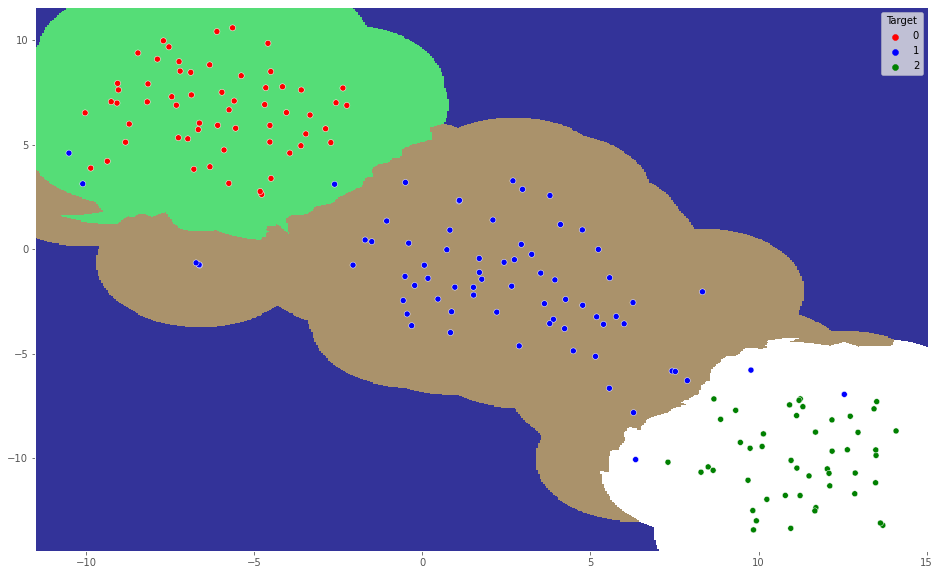

In [33]:
print_border_pw(3)

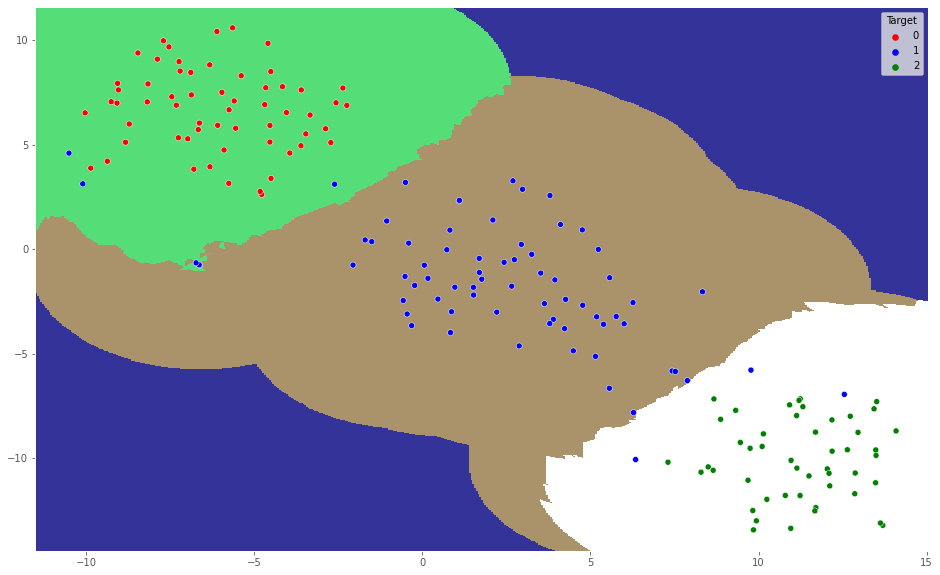

In [34]:
print_border_pw(5)

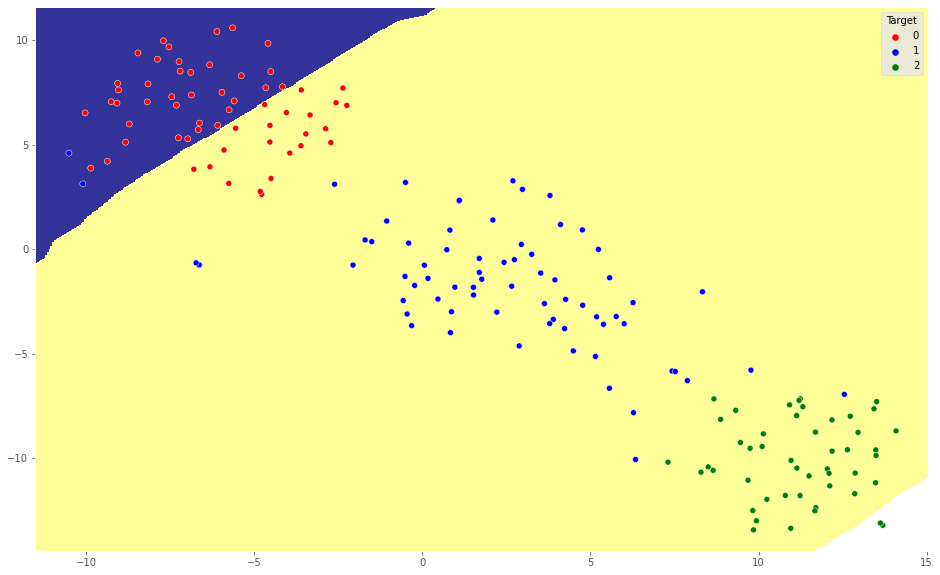

In [35]:
print_border_pw(20)

In [36]:
score = []
for i in range(3, 101):
    est = ParsenWindowEpachnikov(kernel_size=i)
    cv = KFold(n_splits=5, shuffle=True)
    vals = []
    for train_idx, test_idx in cv.split(np.arange(df.shape[0])):
        scaler = StandardScaler()
        train_data = df.iloc[train_idx].drop('Target', axis=1)
        train_data = scaler.fit_transform(train_data)
        test_data = df.iloc[test_idx].drop('Target', axis=1)
        test_data = scaler.transform(test_data)
        est.fit(train_data, df.iloc[train_idx]['Target'].values)
        predict = est.predict(test_data)
        vals.append(1 - accuracy_score(df.iloc[test_idx]['Target'].values, predict))
    score.append(np.mean(vals))

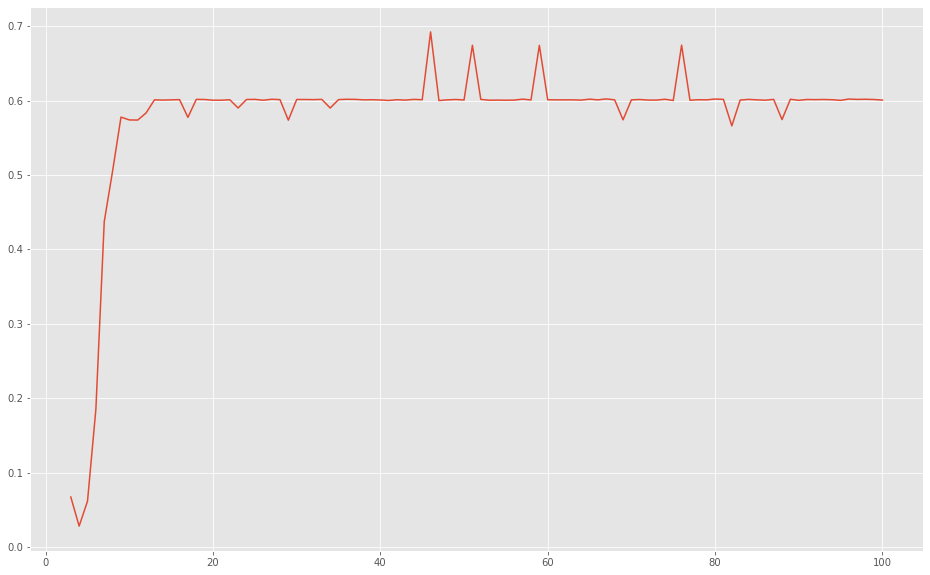

In [37]:
plt.plot(np.arange(3, 101), score);

In [38]:
min(score)

0.028412698412698424

In [39]:
np.argmin(score) + 3

4

Как видно алгоритм парзеновского окна справился лучше с задачей и на расстоянии равным 5 мы получаем долю ошибок менее трех процентов
Так же можно совместить 2 подхода KNN и ParsenWindow и считать функцию ядра не по определенной границе, а устанавливая границу на $k+1$ соседе

In [40]:
class ParsenWindowEpachnikovNeighbors:
    
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors + 1
        self.tree = None
        self.y = None
        self.classes = None
        
    def fit(self, x, y):
        self.tree = KDTree(x)
        self.y = y
        self.classes = np.unique(y)
        
    def predict_proba(self, x):
        dist, idx = self.tree.query(x, self.n_neighbors, return_distance=True)
        if idx.shape[0] == 0:
            return np.zeros((x.shape[0], self.classes.shape[0]))
        pred = np.zeros((x.shape[0], self.classes.shape[0]))
        kernel = self.kernel(dist/dist.max(axis=1).reshape(-1, 1))
        for i in range(idx.shape[0]):
            row_target = self.y[idx[i]]
            for j, cl in enumerate(self.classes):
                cl_id = np.where(row_target == cl)[0]
                if cl_id.shape[0] > 0:
                    pred[i, j] = kernel[i][cl_id].sum()
        pred_sum = pred.sum(axis=1).reshape(-1, 1)
        pred_sum[pred_sum == 0] = 1
        pred /= pred_sum
        return pred
    
    def predict(self, x):
        proba = self.predict_proba(x)
        unnknown_idx = proba.sum(axis=1) == 0
        predict = np.argmax(proba, axis=1)
        predict[unnknown_idx] = -1
        return predict
            
    @staticmethod
    def kernel(r):
        k = 3/4*(1 - r**2)
        k[k < 0] = 0
        return k

In [41]:
def print_border_pwn(n_neighbors):
    clf = ParsenWindowEpachnikovNeighbors(n_neighbors=n_neighbors)
    clf.fit(x, df['Target'].values)
    predict = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    predict = predict.reshape(xx.shape)
    plt.pcolormesh(xx, yy, predict, cmap='terrain');
    sns.scatterplot(x[:, 0], x[:, 1], hue=df['Target'], palette=['red', 'blue', 'green']);

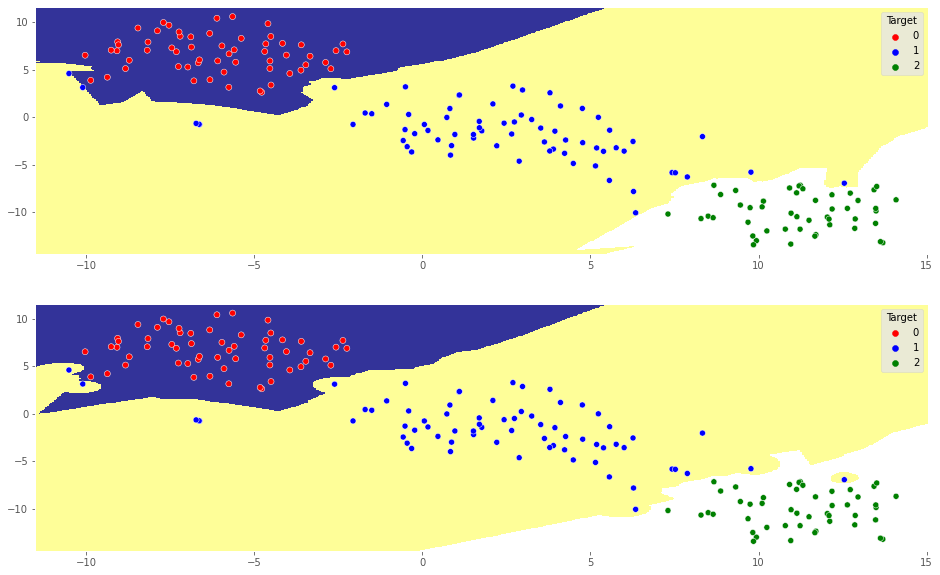

In [42]:
plt.subplot(2, 1, 1);
print_border_pwn(3)
plt.subplot(2, 1, 2);
print_border(3)

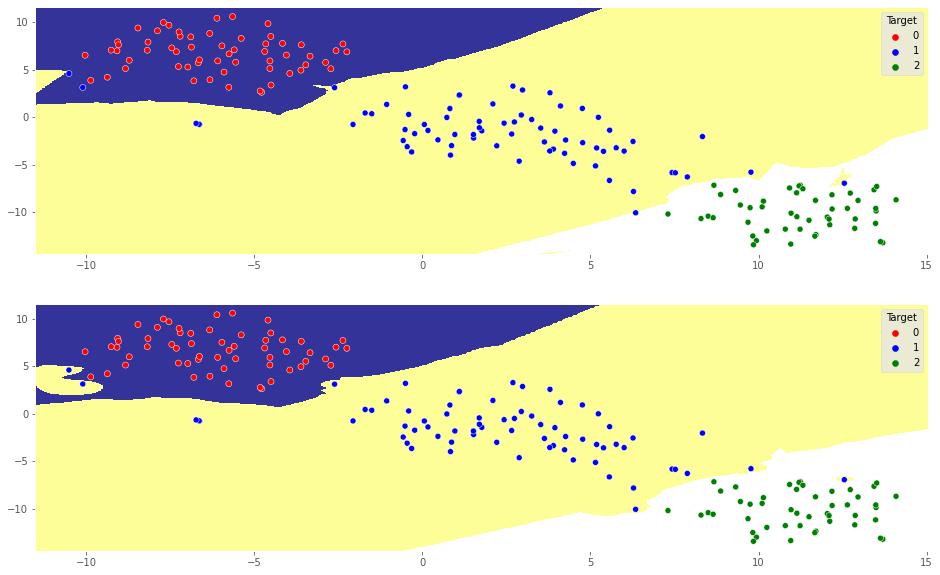

In [43]:
plt.subplot(2, 1, 1);
print_border_pwn(5)
plt.subplot(2, 1, 2);
print_border(5)

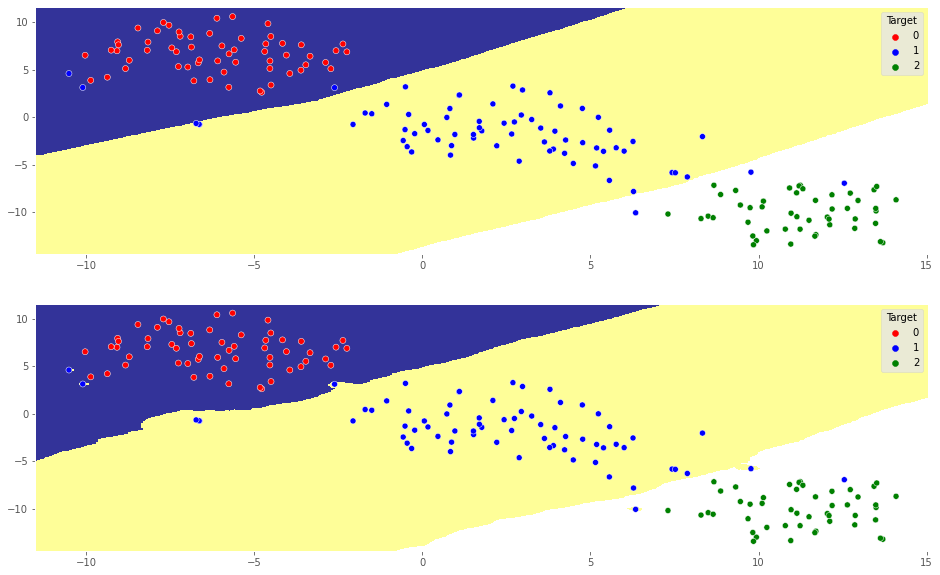

In [44]:
plt.subplot(2, 1, 1);
print_border_pwn(25)
plt.subplot(2, 1, 2);
print_border(25)

Как видно окно дает более гладкие границы по сравнению с KNN

In [45]:
score = []
for i in range(1, 101):
    est = ParsenWindowEpachnikovNeighbors(n_neighbors=i)
    cv = KFold(n_splits=5, shuffle=True)
    vals = []
    for train_idx, test_idx in cv.split(np.arange(df.shape[0])):
        scaler = StandardScaler()
        train_data = df.iloc[train_idx].drop('Target', axis=1)
        train_data = scaler.fit_transform(train_data)
        test_data = df.iloc[test_idx].drop('Target', axis=1)
        test_data = scaler.transform(test_data)
        est.fit(train_data, df.iloc[train_idx]['Target'].values)
        predict = est.predict(test_data)
        vals.append(1 - accuracy_score(df.iloc[test_idx]['Target'].values, predict))
    score.append(np.mean(vals))

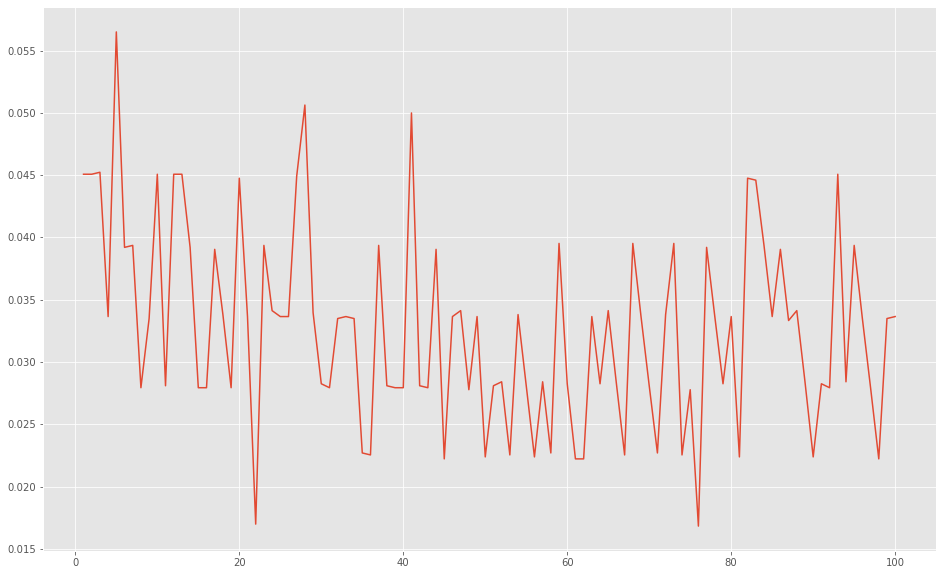

In [46]:
plt.plot(np.arange(1, 101), score);

In [47]:
min(score)

0.016825396825396834

In [48]:
np.argmin(score)

75

В данной имплементации доля ошибок в последнем подходе при числе соседей равным 49, менее двух процентов

## Плюсы и минусы метода ближайших соседей

<b>Плюсы:</b>

- Простая реализация
- Можно адаптировать под нужную задачу выбором метрики или ядра
- Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 – плохие, что на 12% больше, чем в среднем по выборке").

<b>Минусы:</b>

- Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
- Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
- Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
- Нет теоретических оснований выбора определенного числа соседей - только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
- Как правило, плохо работает, когда признаков много, из-за "прояклятия размерности".

## Полезные материалы

https://youtu.be/l1xGQMowWA4?list=PLJOzdkh8T5kp99tGTEFjH_b9zqEQiiBtC - лекция Константина Воронцова по метрическим моделям